In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np

In [2]:
#working Directory
#os.chdir('C:/Users/aksha/Downloads')
conn = psycopg2.connect(
  port='5432',
  host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
  password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
  database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db"
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            o.total_price as order_amount,
            oli.name as product_name,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

<ipython-input-4-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [5]:
data

,order_id,order_date,user_id,product_id,order_amount,product_name,order_status,quantity,sp
0,4936354201774,2023-04-30,6422710747310,7.726612e+12,1399.0,Blue Block Computer Glasses with anti-reflecti...,Delivered,1,1299.0
1,4931918528686,2023-04-26,6376003436718,7.270624e+12,2600.0,Aspire Pro Monthly Disposable Contact Lens Coo...,Delivered,2,1300.0
2,5197214744750,2023-11-25,6729164030126,7.290667e+12,1300.0,Polylite Monthly Color Disposable Contact Lens...,Delivered,1,650.0
3,5197214744750,2023-11-25,6729164030126,7.290667e+12,1300.0,Polylite Monthly Color Disposable Contact Lens...,Delivered,1,650.0
4,5195141972142,2023-11-24,6727545618606,7.249161e+12,1399.0,Power Swimming Goggles FEIKE Rx Prescription O...,Delivered,1,1399.0
...,...,...,...,...,...,...,...,...,...
2880,3970425356462,2021-08-20,5427174932654,7.249161e+12,1399.0,Power Swimming Goggles Aryca Rx Prescription O...,Delivered,1,1399.0
2881,3969532985518,2021-08-19,5426393317550,7.253349e+12,600.0,Affaires Clear UV Contact Lenses Yearly Dispos...,Cancelled,1,600.0
2882,3969315209390,2021-08-19,5426204672174,7.253567e+12,899.0,SOFLENS 59 - BAUSCH & LOMB (Monthly) (6 Lenses...,Delivered,1,899.0
2883,3969073283246,2021-08-19,5425893015726,7.251689e+12,599.0,Affaires Magnetic Reading Spectacle Glasses Fo...,Delivered,1,599.0


In [6]:
data.shape

(2885, 9)

In [7]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [8]:
nan_values = data.isna().sum()

In [9]:
nan_values

order_id         0
order_date       0
user_id          0
product_id      49
order_amount     0
product_name     0
order_status     0
quantity         0
sp               0
dtype: int64

In [10]:
data['WeekCount']=data['order_date'].dt.strftime('%y-w%U')

In [11]:
data = data.dropna()

In [12]:
data.shape

(2836, 10)

In [13]:
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [14]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [15]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [16]:
weeklyusersegsats = {}
for x in output_list:
  x3 = data[data['WeekCount'] <= x]

  userweeklydata = x3.groupby("user_id").agg(
        Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(2).min()),
        First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
        OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
        Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
        ).reset_index()

  globalmaxdateweek=x3['order_date'].max()
  userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
  userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
  userweeklydata['Activated_Quater']=userweeklydata['First_Date'].dt.to_period('Q')
  userweeklydata['Maturity_Age']=userweeklydata['Last_Date']-userweeklydata['First_Date']
  userweeklydata['Maturity_Age']=userweeklydata['Maturity_Age'].dt.days.abs()
  userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
  userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
  userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

  r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
  userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
  userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
  userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
  userweeklydata['m_score'] = userweeklydata['Maturity_Age'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
  userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
  userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
  def CohortLables(df):
      if df['SumScore'] >= 18:
          return 'Champions'
      elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
          return 'New&Potential'
      elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
          return 'Mature&Loyal'
      elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
          return 'Mature&Slow'
      elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
          return 'New&Slow'
      elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
          return 'Mature&ChurnRisk'
      else:
          return 'Churned'

  userweeklydata['CohortLabel'] = userweeklydata.apply(CohortLables, axis=1)

  usersegstats=userweeklydata.groupby(
    'CohortLabel'
  ).agg(
        Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Orders=pd.NamedAgg(column='OrdersCount', aggfunc='sum'),
        Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
        OrderValue=pd.NamedAgg(column='Order_Value', aggfunc='sum'),
        MeanDaysDelta=pd.NamedAgg(column='Mean_Days_Delta', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='Mean_OV_Delta', aggfunc='mean'),
        Maturity=pd.NamedAgg(column='Maturity_Age', aggfunc='mean'),
  )

  usersegstats["Frequency"] = usersegstats["Orders"] / usersegstats["Users"]
  usersegstats["AOVContribution"] = usersegstats["OrderValue"] / usersegstats["Orders"].sum()
  usersegstats["AOV"] = usersegstats["OrderValue"] / usersegstats["Orders"]
  user_cohort_labels = ['Champions', 'Churned', 'Mature&ChurnRisk', 'Mature&Loyal', 'Mature&Slow', 'New&Potential', 'New&Slow']
  col_len = len(usersegstats.columns.tolist())
  usersegstats=usersegstats.sort_values('CohortLabel', ascending= True)
  xyz = usersegstats.index.tolist()
  if usersegstats.index.tolist() != user_cohort_labels:
    abc = [p for p in user_cohort_labels if p not in xyz]
    for j in abc:
      new_row_values = [0] * (col_len)
      new_row_data = pd.Series(new_row_values, index=usersegstats.columns, name=j)
      usersegstats = usersegstats.append(new_row_data)
    # usersegstats=usersegstats.sort_index()
  weeklyusersegsats[x] = usersegstats

<ipython-input-16-d680709d855d>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usersegstats = usersegstats.append(new_row_data)
<ipython-input-16-d680709d855d>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usersegstats = usersegstats.append(new_row_data)
<ipython-input-16-d680709d855d>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usersegstats = usersegstats.append(new_row_data)
<ipython-input-16-d680709d855d>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usersegstats = usersegstats.append(new_row_data)
<ipython-input-16-d680709d855d>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [17]:
userweeklydata

,user_id,Last_Date,First_Date,OrdersCount,Order_Value,Mean_Days_Delta,Mean_OV_Delta,Recency,Activated_Quater,Maturity_Age,Customer_AOV,f_score,r_score,AOV_score,m_score,DelAOV,SumScore,CohortLabel
0,5422063714478,2021-08-17,2021-08-17,1,1000.0,0.0,0.0,836,2021Q3,0,1000.0,1,1,1,1,1,5,Churned
1,5425893015726,2021-08-19,2021-08-19,1,599.0,0.0,0.0,834,2021Q3,0,599.0,1,1,1,1,1,5,Churned
2,5426204672174,2021-08-19,2021-08-19,1,899.0,0.0,0.0,834,2021Q3,0,899.0,1,1,1,1,1,5,Churned
3,5426393317550,2021-08-19,2021-08-19,1,600.0,0.0,0.0,834,2021Q3,0,600.0,1,1,1,1,1,5,Churned
4,5427174932654,2021-08-20,2021-08-20,1,1399.0,0.0,0.0,833,2021Q3,0,1399.0,1,1,2,1,1,6,Churned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,6740847001774,2023-11-30,2023-11-30,1,1000.0,0.0,0.0,1,2023Q4,0,1000.0,4,4,2,4,4,18,Champions
1874,6740947435694,2023-11-30,2023-11-30,1,999.0,0.0,0.0,1,2023Q4,0,999.0,4,4,1,4,4,17,Mature&Loyal
1875,6741147058350,2023-11-30,2023-11-30,1,5648.0,0.0,0.0,1,2023Q4,0,5648.0,4,4,4,4,4,20,Champions
1876,6741484503214,2023-11-30,2023-11-30,1,2190.0,0.0,0.0,1,2023Q4,0,2190.0,4,4,4,4,4,20,Champions


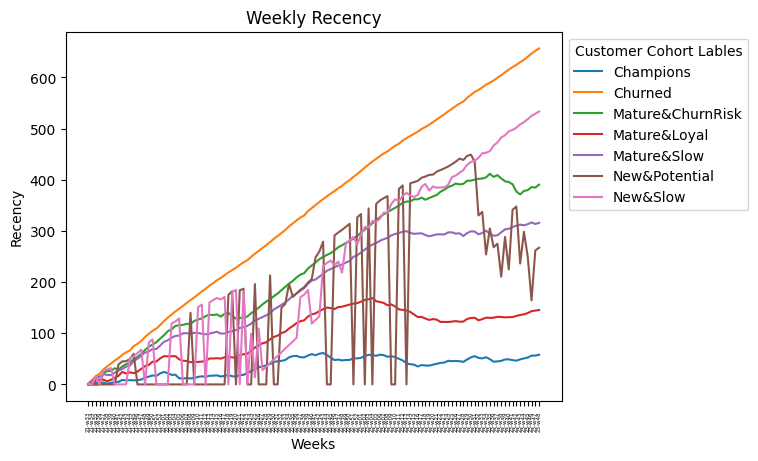

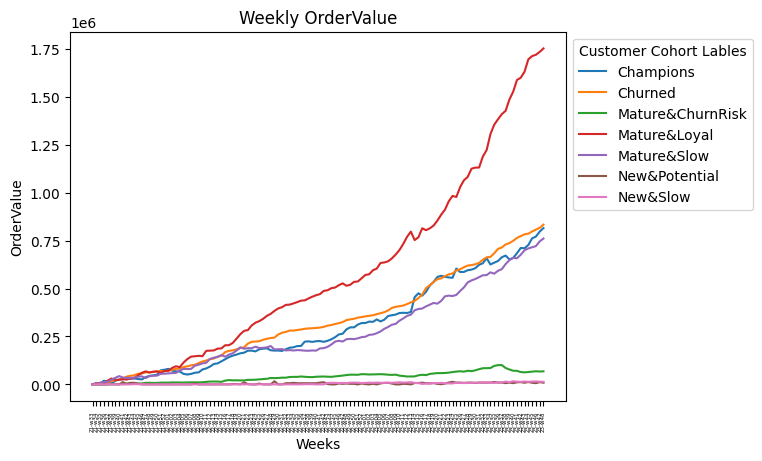

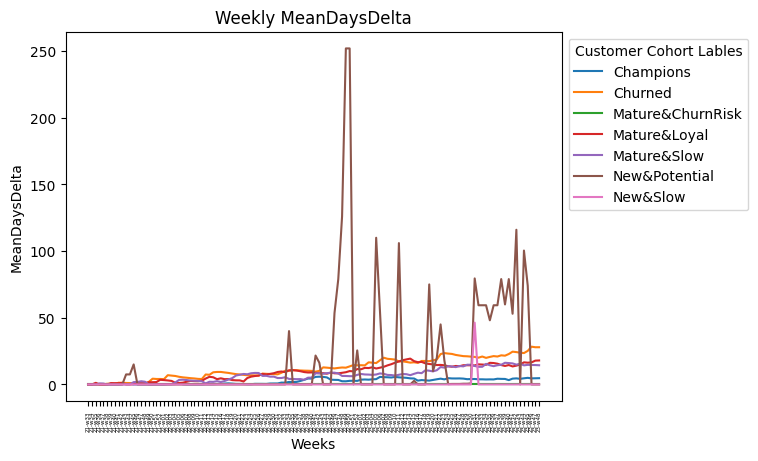

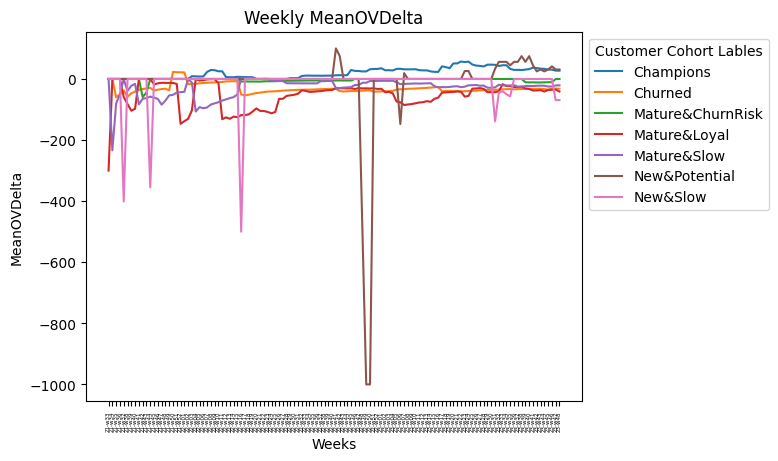

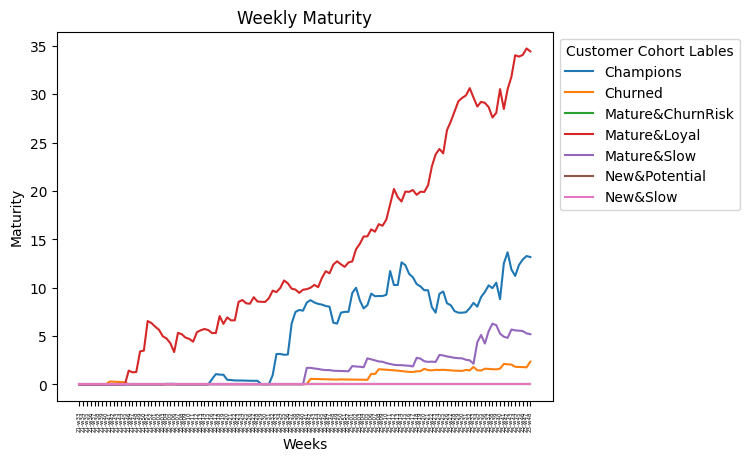

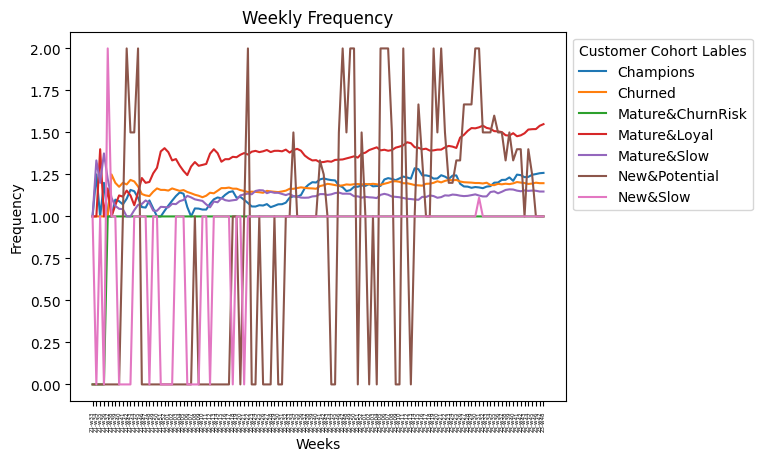

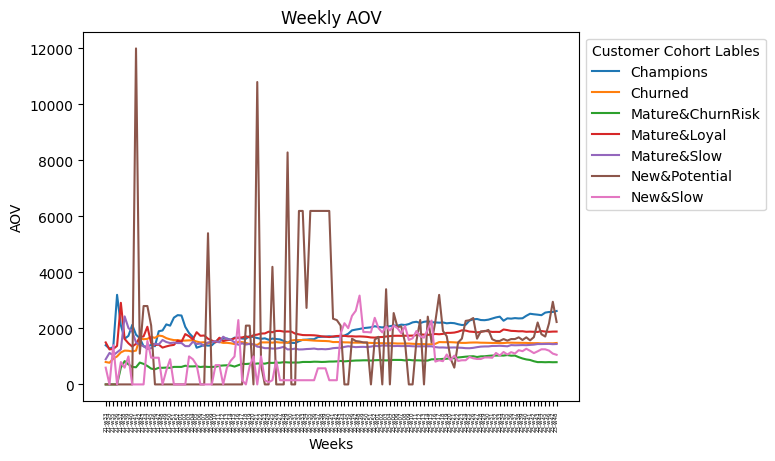

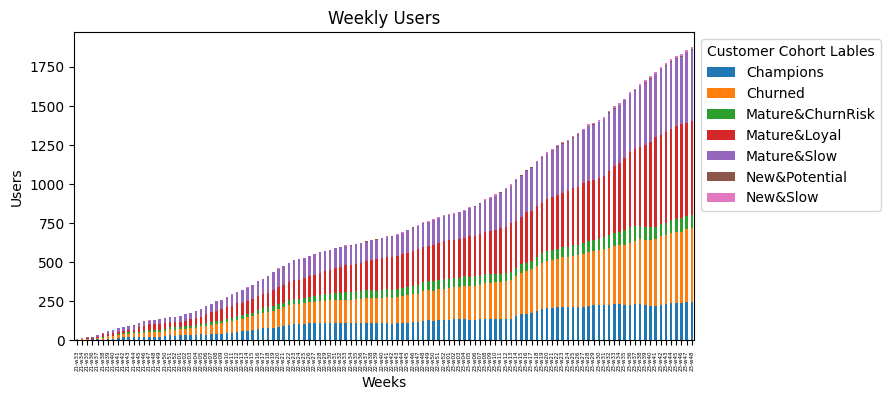

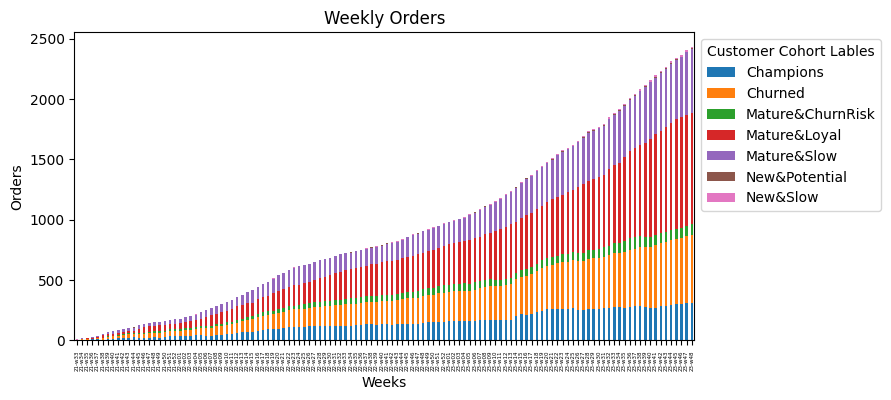

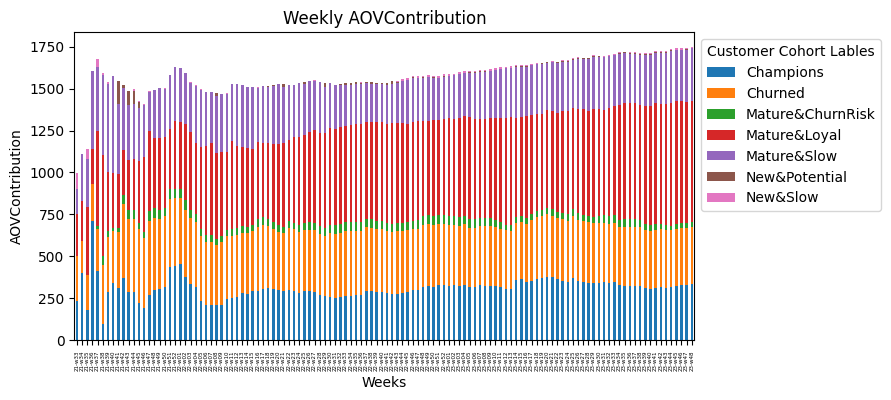

In [18]:
each_metric_df = {}
ListofCustomerCohortVariables = usersegstats.columns.to_list()
Line_Chart_Variable_List_Customer = ['Recency', 'OrderValue', 'MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV']
Stack_Chart_Variable_List_Customer = ['Users', 'Orders', 'AOVContribution']
for week, df in weeklyusersegsats.items():
    df.sort_index(inplace=True)

for x in Line_Chart_Variable_List_Customer:
  column_df = pd.DataFrame({week: df[x].tolist() for week, df in weeklyusersegsats.items()})
  column_df.index = user_cohort_labels
  column_transposed = column_df.transpose()
  each_metric_df[x] = column_transposed
  weeks = column_transposed.index.to_list()
  for column_name, values in column_transposed.items():
    plt.plot(weeks, values, label=column_name)
  plt.xlabel('Weeks')
  plt.ylabel(x)
  plt.title(f'Weekly {x}')
  plt.xticks(fontsize=4, rotation=90)
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
  plt.show()

for x in Stack_Chart_Variable_List_Customer:
  variable_df = pd.DataFrame({week: df[x].tolist() for week, df in weeklyusersegsats.items()})
  variable_df.index = user_cohort_labels
  variable_df_transposed = variable_df.transpose()
  each_metric_df[x] = variable_df_transposed
  graph2 = variable_df_transposed
  graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
  plt.title(f'Weekly {x}')
  plt.xticks(fontsize=4)
  plt.xlabel('Weeks')
  plt.ylabel(x)
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
  plt.show()


In [ ]:
each_metric_df['Users'].to_csv('users.csv')

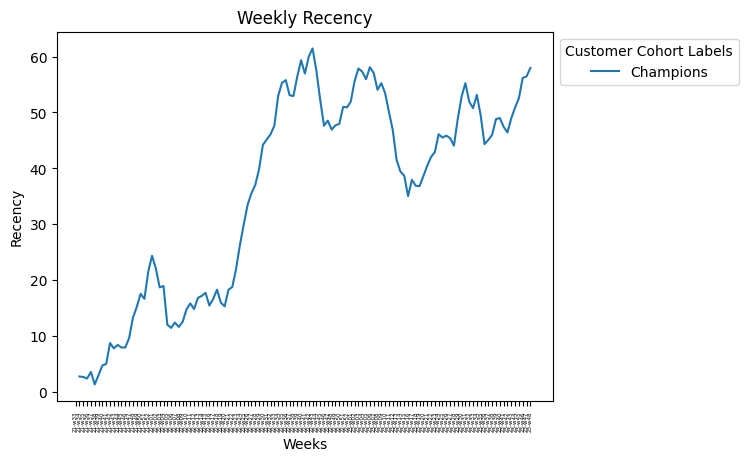

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def metric_cohort_graph(metric, cohort):
    if metric in Line_Chart_Variable_List_Customer:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
        column_df.index = user_cohort_labels
        column_transposed = column_df.transpose()
        each_metric_df[metric] = column_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        plt.plot(column_transposed.index, each_metric_df[metric], label=cohort)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Customer:
        variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in weeklyusersegsats.items()})
        variable_df.index = user_cohort_labels
        variable_df_transposed = variable_df.transpose()
        each_metric_df[metric] = variable_df_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        graph2 = pd.DataFrame({cohort: each_metric_df[metric]})
        graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

# Call the function with the specified metric and cohort
result = metric_cohort_graph('Recency', 'Champions')
